In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()


from subprocess import check_output
print(check_output(["ls","bitcoin"]).decode("utf8"))

bitcoin_price_1week_Test - Test.csv
bitcoin_price_Training - Training.csv



In [2]:
pip install scikit-learn-intelex

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
train = pd.read_csv("bitcoin/bitcoin_price_Training - Training.csv")
test = pd.read_csv("bitcoin/bitcoin_price_1week_Test - Test.csv")

In [4]:
train = train[::-1]
test = test[::-1]

In [5]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [6]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [9]:
print(train_n.shape)
print(test_n.shape)

(1556, 1)
(7, 1)


In [10]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [11]:
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)
val_steps = (len(train_n) - 1001 - lookback) // batch_size
test_steps = (len(test_n) - lookback) // batch_size


In [12]:
np.random.seed(7)

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

2023-09-14 06:44:46.988500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

2023-09-14 06:45:04.377834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/home/u202094/tmp/ipykernel_2476692/4276881377.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
100/100 [==============================] - 14s 110ms/step - loss: 0.2114 - val_loss: 0.4883
Epoch 2/20
100/100 [==============================] - 10s 95ms/step - loss: 0.1097 - val_loss: 0.4595
Epoch 3/20
100/100 [==============================] - 9s 94ms/step - loss: 0.1069 - val_loss: 0.4555
Epoch 4/20
100/100 [==============================] - 10s 102ms/step - loss: 0.1055 - val_loss: 0.4644
Epoch 5/20
100/100 [==============================] - 9s 90ms/step - loss: 0.1048 - val_loss: 0.4721
Epoch 6/20
100/100 [==============================] - 10s 97ms/step - loss: 0.1038 - val_loss: 0.4649
Epoch 7/20
100/100 [==============================] - 10s 100ms/step - loss: 0.1030 - val_loss: 0.4577
Epoch 8/20
100/100 [==============================] - 10s 99ms/step - loss: 0.1013 - val_loss: 0.4486
Epoch 9/20
100/100 [==============================] - 10s 103ms/step - loss: 0.1004 - val_loss: 0.4161
Epoch 10/20
100/100 [==============================] - 11s 111ms/step - loss: 0.

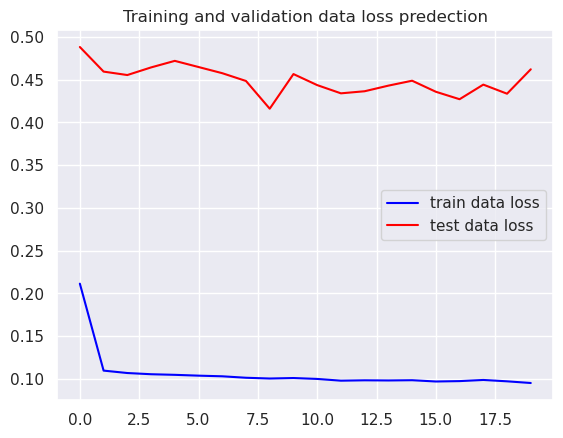

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'blue', label='train data loss')
plt.plot(epochs, val_loss, 'red', label='test data loss')
plt.title('Training and validation data loss predection')
plt.legend()

In [17]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

49/49 [==============================] - 1s 5ms/step


In [18]:
pred = scaler.inverse_transform(pred)

Text(0.5, 1.0, 'Prediction on bitcoin data')

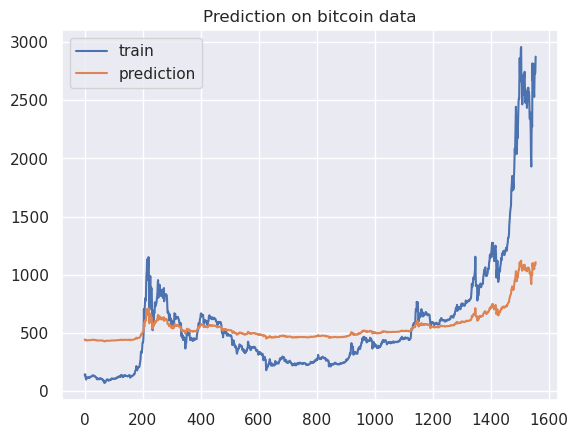

In [19]:
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), pred, label='prediction')
plt.legend()

plt.title("Prediction on bitcoin data")